In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import scipy.stats
import numpy.matlib
import matplotlib.pyplot as plt
import time
from SSH import *

In [2]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)

# von Neumann entropy

In [3]:
def generate_A_dep(w):
    subregion_max_list=np.arange(2,50,2)
    von_Neumann_entropy_list[w]=[]
    params=Params(w=w,L=200)
    for subregion_max in subregion_max_list:
        von_Neumann_entropy_list[w].append(params.von_Neumann_entropy(np.arange(subregion_max)))

In [4]:
def generate_A_dep_2(w):
    subregion_max_list=np.arange(20,100,2)
    von_Neumann_entropy_list[w]=[]    
    for subregion_max in subregion_max_list:
        params=Params(w=w,L=subregion_max*4)
        von_Neumann_entropy_list[w].append(params.von_Neumann_entropy(np.arange(subregion_max)))

In [5]:
von_Neumann_entropy_list={}
for i in (0,0.5,0.8,1,2):
    generate_A_dep(i)

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [ ]:
for i in (0,0.5,.8,1,2):
    generate_A_dep_2(i)

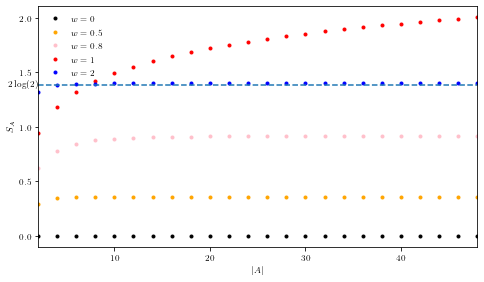

In [8]:
fig,ax=plt.subplots(figsize=(6.8,4))
subregion_max_list=np.arange(2,50,2)
for i,color in zip((0,0.5,0.8,1,2),('k','orange','pink','red','b')):
    ax.plot(subregion_max_list,von_Neumann_entropy_list[i],'.',label=r'$w={}$'.format((i)),color=color)
ax.legend(framealpha=0)
# ax.plot(subregion_max_list,1/3*np.log(subregion_max_list))
ax.margins(x=0)
ax.axhline(y=2*np.log(2),ls='--')
ax.text(2,2*np.log(2),r'$2\log(2)$',ha='right',va='center')
ax.set_xlabel(r'$|A|$')
ax.set_ylabel(r'$S_A$')
ax.set_yticks(np.arange(0,2.5,0.5))

fig.tight_layout()

fig.savefig('/mnt/d/kitp/Rp_SPT/1/SA_vs_A_L_fixed.pdf',bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots(figsize=(6.8,4))
ax.plot(np.log(subregion_max_list),(von_Neumann_entropy_list[1]))
ax.set_xlabel(r'$\log(|A|)$')
ax.set_ylabel(r'$S_A$')
lr=scipy.stats.linregress(np.log(subregion_max_list),(von_Neumann_entropy_list[1]))
ax.text(0.1,0.9,r'Fitted $y={:.4f}~x+ {:.4f}$'.format(lr.slope,lr.intercept),transform=ax.transAxes)
fig.savefig('/mnt/d/kitp/Rp_SPT/1/critical_exponent.pdf',bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots(figsize=(6.8,4))
subregion_max_list=np.arange(20,100,2)
for i,color in zip((0,0.5,0.8,1,2),('k','orange','pink','red','b')):
    ax.plot(subregion_max_list,von_Neumann_entropy_list[i],'.',label=r'$\mu={}$'.format((i)),color=color)
ax.legend()
# ax.plot(subregion_max_list,1/3*np.log(subregion_max_list))
ax.margins(x=0)
ax.axhline(y=np.log(2),ls='--')
ax.text(-1,np.log(2),r'$\log(2)$')
ax.set_xlabel(r'$|A|$')
ax.set_ylabel(r'$S_A$')

# fig.savefig('/mnt/d/kitp/Rp_SPT/1/SA_vs_A_L_fixed.pdf',bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots(figsize=(6.8,4))
ax.plot(np.log(subregion_max_list),(von_Neumann_entropy_list[1]))
ax.set_xlabel(r'$\log(|A|)$')
ax.set_ylabel(r'$S_A$')
ax.text(0.1,0.9,r'Fitted $y=0.1676~x+ 0.354$',transform=ax.transAxes)
# fig.savefig('/mnt/d/kitp/Rp_SPT/1/critical_exponent.pdf',bbox_inches='tight')

In [ ]:
w_list=np.linspace(0.01,2,50)
von_Neumann_entropy_w_list=[]
spectrum_gap_list=[]
for w in w_list:
    params=Params(w=w,L=100)
    von_Neumann_entropy_w_list.append(params.von_Neumann_entropy(np.arange(10)))
    val=params.val
    spectrum_gap_list.append(np.max(val[val<0])-np.min(val[val>0]))

In [ ]:
plt.plot(w_list,von_Neumann_entropy_w_list)
plt.plot(w_list,np.abs(spectrum_gap_list))

In [ ]:
plt.plot(w_list,np.abs(spectrum_gap_list))

In [ ]:
derivative=(np.array(von_Neumann_entropy_w_list[2:])-np.array(von_Neumann_entropy_w_list[:-2]))/(w_list[1]-w_list[0])

In [ ]:
plt.plot(w_list[1:-1],np.abs(derivative))

In [ ]:
fig,ax=plt.subplots()
for index in range(eigvallist[0].shape[0]):
    ax.plot(wlist,np.array(eigvallist)[:,index],'k')
    ax.set_ylim([-2,2])


# Mutual information

In [9]:
MI_list={}

## w=0.5

In [10]:
dist_list=np.arange(10,50,2)
MI_list[0.5]=[]
params=Params(w=0.5,L=200)
for dist in dist_list:
    MI_list[.5].append(params.mutual_information(np.arange(10),np.arange(dist,dist+10)))

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


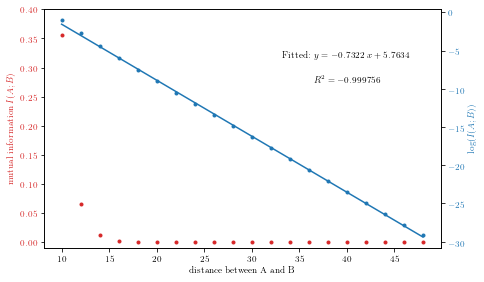

In [15]:
fig,ax1=plt.subplots(figsize=(6.8,4))

color = 'tab:red'
ax1.set_xlabel('distance between A and B')
ax1.set_ylabel(r'mutual information $I(A;B)$', color=color)
ax1.plot(dist_list,MI_list[.5],'.', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-0.01,0.4)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel(r'$\log(I(A;B))$', color=color)  
ax2.plot(dist_list,np.log(MI_list[.5]),'.', color=color)
ax2.tick_params(axis='y', labelcolor=color)
lr=scipy.stats.linregress(dist_list,np.log(MI_list[.5]))
ax2.text(.6,.8,r'Fitted: $y={:.4f}~x+{:.4f}$'.format(lr.slope,lr.intercept),transform=ax2.transAxes)
ax2.text(.68,.7,r'$R^2={:f}$'.format(lr.rvalue),transform=ax2.transAxes)

ax2.plot(dist_list,lr.slope*dist_list+lr.intercept,color=color)

fig.tight_layout()


fig.savefig('/mnt/d/kitp/Rp_SPT/1/MI_mu0.5.pdf',bbox_inches='tight')


# w=2

In [ ]:
dist_list=np.arange(10,50,2)
MI_list[2]=[]
params=Params(w=2,L=200)
for dist in dist_list:
    MI_list[2].append(params.mutual_information(np.arange(10),np.arange(dist,dist+10)))

In [ ]:
fig,ax1=plt.subplots(figsize=(6.8,4))

color = 'tab:red'
ax1.set_xlabel('distance between A and B')
ax1.set_ylabel(r'mutual information $I(A;B)$', color=color)
ax1.plot(dist_list,MI_list[2],'.-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel(r'$\log(I(A;B))$', color=color)  
ax2.plot(dist_list,np.log(MI_list[2]), color=color)
ax2.tick_params(axis='y', labelcolor=color)
lr=scipy.stats.linregress(dist_list,np.log(MI_list[2]))
ax2.text(.6,.8,r'Fitted: $y={:.4f}~x+{:.4f}$'.format(lr.slope,lr.intercept),transform=ax2.transAxes)
ax2.text(.68,.7,r'$R^2={:f}$'.format(lr.rvalue),transform=ax2.transAxes)

fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/1/MI_mu2.pdf',bbox_inches='tight')


In [ ]:
1/lr.slope

## w=1

In [ ]:
dist_list=np.arange(10,190,2)
MI_list[1]=[]
params=Params(w=1,L=200)
for dist in dist_list:
    MI_list[1].append(params.mutual_information(np.arange(10),np.arange(dist,dist+10)))

In [ ]:
fig=plt.figure()
ax1=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2",frame_on=False)

color = 'tab:red'
ax1.set_xlabel('distance between A and B', color=color)
ax1.set_ylabel(r'mutual information $I(A;B)$', color=color)
ax1.plot(dist_list,MI_list[1],'.-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelcolor=color)

color = 'tab:blue'
ax2.plot(np.log(dist_list),np.log(MI_list[1]), color=color)
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.set_xlabel(r'log distance', color=color)
ax2.set_ylabel(r'$\log(I(A;B))$', color=color)  
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='x', labelcolor=color)

lr=scipy.stats.linregress(np.log(dist_list),np.log(MI_list[1]))
ax2.text(.6,.8,r'Fitted: $y={:.4f}~x+{:.4f}$'.format(lr.slope,lr.intercept),transform=ax2.transAxes)
ax2.text(.68,.7,r'$R^2={:f}$'.format(lr.rvalue),transform=ax2.transAxes)

fig.tight_layout()

fig.savefig('/mnt/d/kitp/Rp_SPT/1/MI_mu1.pdf',bbox_inches='tight')

# Class

In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la

In [4]:
class Params:
    def __init__(self,
    L=100,
    v=1,
    w=1,
    T=0,
    pbc=True):
        self.L=L
        self.v=v
        self.w=w
        self.T=T
        self.pbc=pbc
        band=np.vstack([np.ones(L)*v,np.ones(L)*w]).flatten('F')        
        Ham=sp.diags(np.array([band[:-1],band[:-1]]),np.array([-1,1]),shape=(2*L,2*L)).tocsr()
        Ham[0,2*L-1]=w*pbc
        Ham[2*L-1,0]=w*pbc
        self.Hamiltonian=Ham

    def fermi_dist(self,energy,E_F):      
        if self.T==0:
            return np.heaviside(E_F-energy,0)
        else:
            return 1/(1+np.exp((energy-E_F)/self.T))

    def bandstructure(self):
        val,vec=la.eigh(self.Hamiltonian.toarray())
        sortindex=np.argsort(val)
        self.val=val[sortindex]
        self.vec=vec[:,sortindex]

    def covariance_matrix_loop(self):
        '''
        Use loop to calculate covariance matrix (deprecated)
        '''
        self.C_loop=np.zeros((2*self.L,2*self.L))
        for i in range(2*self.L):
            for j in range(2*self.L):
                self.C_loop[i,j]=self.c_ij(i,j)

    def covariance_matrix(self,E_F=0):
        if not (hasattr(self,'val') and hasattr(self,'vec')):
            self.bandstructure()
        occupancy=self.fermi_dist(self.val,E_F)
        occupancy_mat=np.matlib.repmat(self.fermi_dist(self.val,E_F),self.vec.shape[0],1)
        self.C=(occupancy_mat*self.vec)@self.vec.T.conj()
        


    def c_ij(self,i,j,E_F=0):
        if not (hasattr(self,'val') and hasattr(self,'vec')):
            self.bandstructure()

        occupancy=self.fermi_dist(self.val,E_F)
        bra_i=self.vec[i,:] # c_i
        ket_j=self.vec[j,:] # c_j
        return np.sum(bra_i.conj()*ket_j*occupancy)

    def c_subregion(self,subregion):
        if not hasattr(self,'C'):
            self.covariance_matrix()
        XX,YY=np.meshgrid(np.arange(2*self.L),np.arange(2*self.L))
        mask=np.isin(XX,subregion)*np.isin(YY,subregion)        
        return self.C[mask].reshape((subregion.shape[0],subregion.shape[0]))

    def von_Neumann_entropy(self,subregion):
        c_A=self.c_subregion(subregion)
        val,vec=la.eigh(c_A)
        self.val_sh=val
        # return np.real(-np.sum(val*np.log(val+1e-18j)))
        return np.real(-np.sum(val*np.log(val+1e-18j))-np.sum((1-val)*np.log(1-val+1e-18j)))

    def mutual_information(self,subregion_A,subregion_B):
        s_A=self.von_Neumann_entropy(subregion_A)
        s_B=self.von_Neumann_entropy(subregion_B)
        subregion_AB=np.hstack([subregion_A,subregion_B])
        s_AB=self.von_Neumann_entropy(subregion_AB)
        return s_A+s_B-s_AB